# Individual Project - Time Series Project on Predicting Crime Counts

# Goal:

  Use the data from kaggle's chicago crime data set in order to predict specific crime counts for next year.

In [1]:
import model as m
import wrangle as w
import pandas as pd
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sqlalchemy import text, create_engine
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt 
from sklearn.linear_model import LinearRegression
import ipywidgets as widgets
from IPython.display import display, HTML

# Acquire
    -Data acquired Kaggle's Chicago Crime dataset(https://www.kaggle.com/datasets/adelanseur/crimes-2001-to-present-chicago)
    -It contained '7842388' rows and '10' columns before cleaning
    -Each row represents a case number
    -Each column represents a feature of that case number
    

#  Prepare

### Prepare Actions:
```
- Checked for nulls in the data 
- Checked that column data types were appropriate
- Split data into train, validate and test 
- created function to acquire and prep data
- function created to split data into train, validate and test
- resample data by day
- unstacked 'Primary Type'
- kept 10 primary type values

```

## Data Dictionary  


#### Data Used
---
| Attribute | Definition | Data Type |
| ----- | ----- | ----- |
|Date| Dates in order by day |int|
|THEFT| Amount of thefts that has occured in a particular day |int|
|BATTERY|Amount of battery that havs occured in a particular day |int|
|ASSAULT| Amount of assault that has occured in a particular day |int|
|CRIMINAL DAMAGE| Amount of criminal damage that has occured in a particular day |int|
|MOTOR VEHICLE THEFT| Amount of motor vehicle theft that has occured in a particular day |int|
|NARCOTICS|Amount of narcotic related crimes that have occured in a particular day |int|
|HOMICIDE| Amount of homicides that have occured in a particular day|int|
|HUMAN TRAFFICKING| Amount of human trafficking that has occured in a particular day |int|
|OFFENSE INVOLVING CHILDREN| Amount of offenses involving children that have occured in a particular day|int|
|KIDNAPPING| Amount of kidnapping that has occured in a particular day |int|

## Quick Data Preview

In [2]:
# split data into train, validate and test
train, validate, test = w.wrangle_crime()

In [3]:
# this previews the training data
train.head()

Primary Type,THEFT,BATTERY,ASSAULT,CRIMINAL DAMAGE,MOTOR VEHICLE THEFT,NARCOTICS,HOMICIDE,HUMAN TRAFFICKING,OFFENSE INVOLVING CHILDREN,KIDNAPPING
Date,,,,,,,,,,
2018-08-04,176,110,46,47,17,22,2,0,4,0
2018-08-05,223,199,77,97,20,18,8,0,4,2
2018-08-06,215,130,52,74,26,35,3,0,7,0
2018-08-07,232,122,46,69,36,32,2,0,5,0
2018-08-08,222,125,63,69,25,33,4,0,4,0


## Data Summary

In [4]:
# provides a quick description of the data
train.describe()

Primary Type,THEFT,BATTERY,ASSAULT,CRIMINAL DAMAGE,MOTOR VEHICLE THEFT,NARCOTICS,HOMICIDE,HUMAN TRAFFICKING,OFFENSE INVOLVING CHILDREN,KIDNAPPING
count,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000
mean,136.877778,122.336111,53.321296,70.012037,25.974074,27.814815,1.833333,0.026852,5.606481,0.372222
std,43.032865,28.658207,10.934954,17.944380,6.547274,14.912502,1.680174,0.161725,3.385319,0.650349
min,37.000000,53.000000,25.000000,25.000000,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,100.000000,103.000000,46.000000,59.000000,22.000000,15.000000,1.000000,0.000000,3.000000,0.000000
50%,134.000000,120.000000,53.000000,69.000000,26.000000,27.500000,1.000000,0.000000,5.000000,0.000000
75%,173.250000,138.000000,61.000000,80.000000,30.000000,40.000000,3.000000,0.000000,7.000000,1.000000
max,272.000000,235.000000,89.000000,341.000000,93.000000,81.000000,19.000000,1.000000,46.000000,5.000000


# Explore

## Which crimes show a correlation with time?

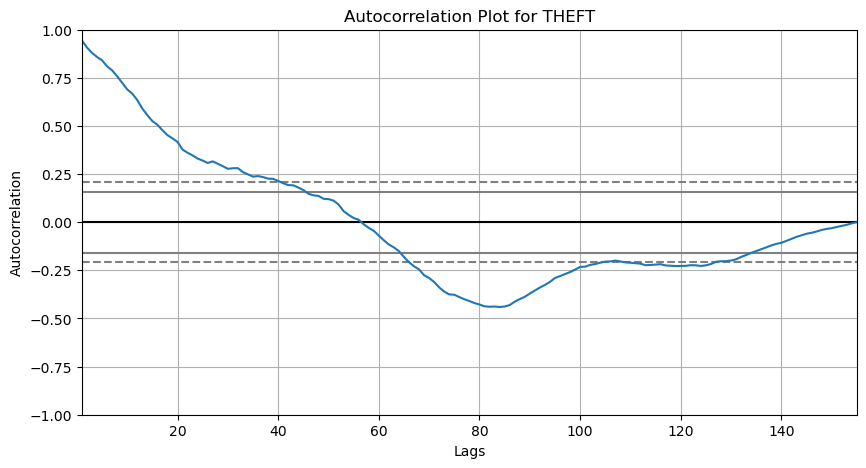

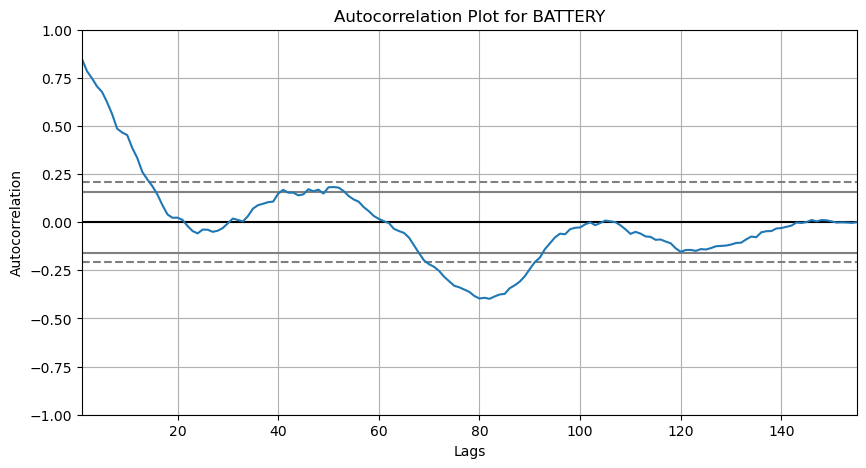

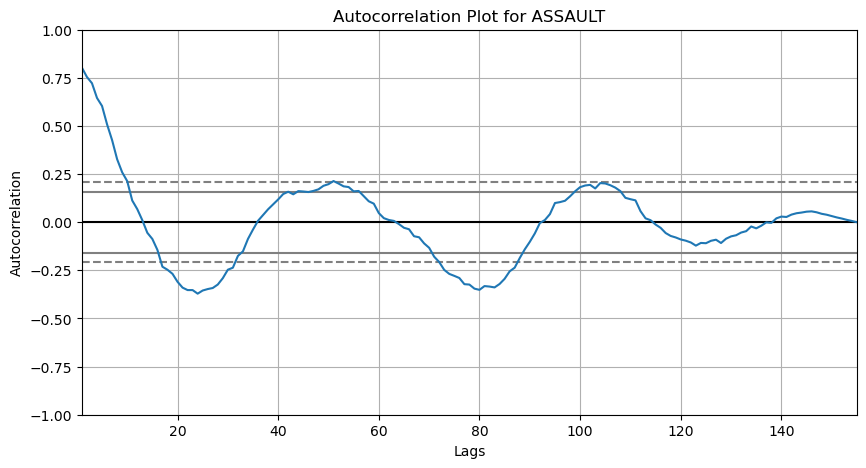

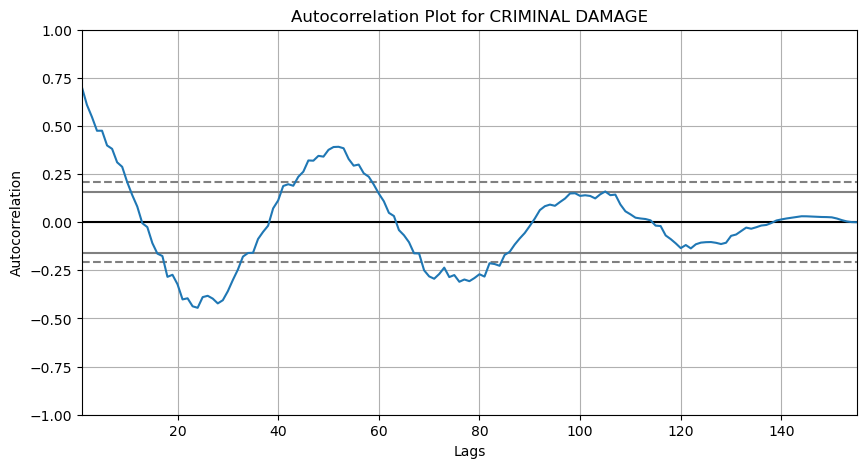

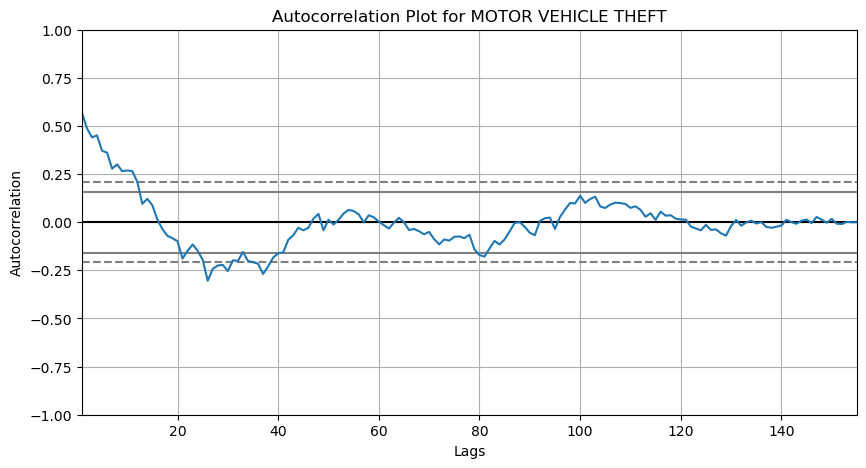

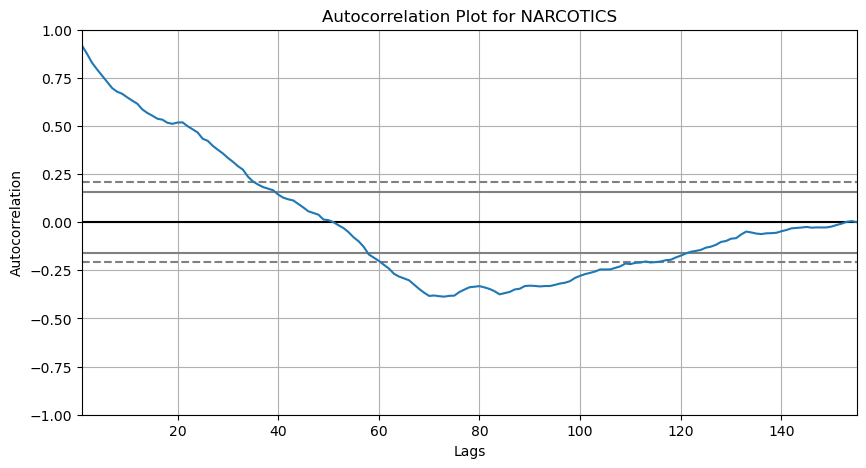

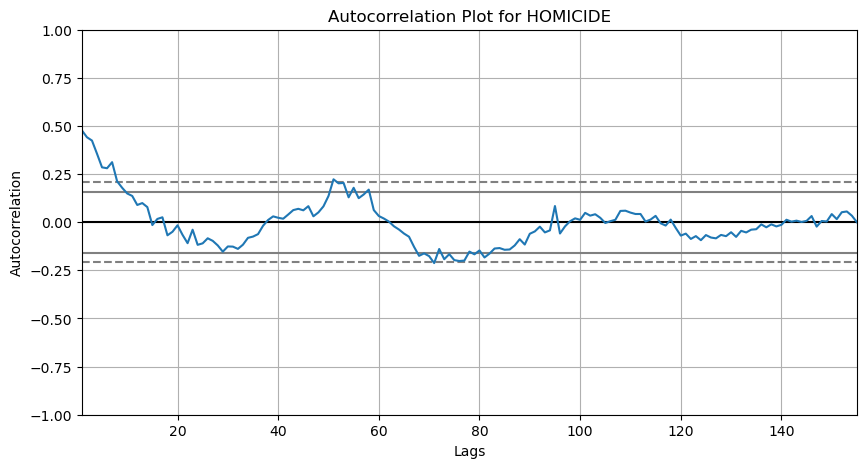

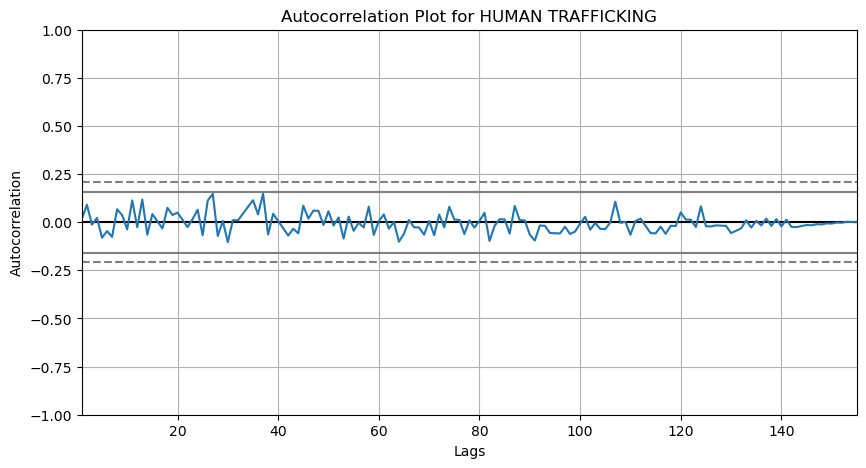

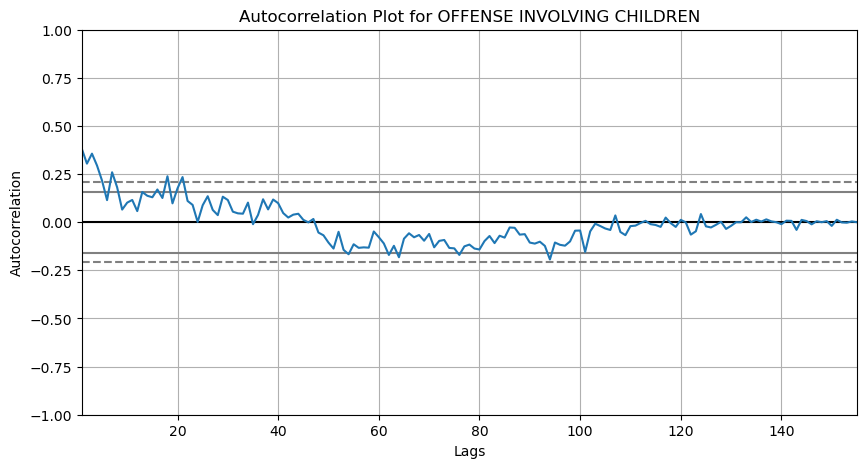

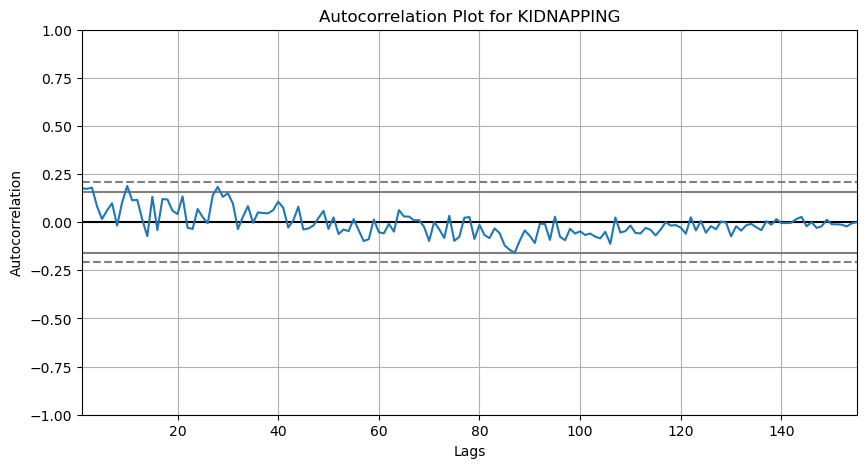

In [5]:
crime_types = train.columns

# Call the function with the train DataFrame and the crime types list
m.plot_autocorrelation(train, crime_types)

 - Visually no apparent correlation except a weak correlation with the following crimes: Assault, battery and criminal damages
 

## Exploration Summary
Assault, battery and criminal damages all seem to have some kind of correlation with time

- Revisisting data for more exploration may be necessary for predictability


## Features being turned into targets for Modeling by creating their own DataFrame's with Lag:

- ASSAULT - (relationship to time is weak but present)

- BATTERY - (relationship to time is weak but present)

- CRIMINAL DAMAGE -  (relationship to time is weak but present)





## Features not moving forward for modeling

```
'THEFT'
'MOTOR VEHICLE THEFT'
'NARCOTICS'
'HOMICIDE'
'HUMAN TRAFFICKING'
'OFFENSE INVOLVING CHILDREN'
'KIDNAPPING'
```
    

## Modeling

- I will use 3 Baseline models to find best baseline RMSE and 2 non-baseline models to find best RMSE

- Best Baseline to use for modeling was Moving Average (30 day window) 
- I will be evaluating models developed using 5 different model types.
- Models will be evaluated on train and validate data 
- The model that performs the best will then be evaluated on test data
- Data will be passed through as lag columns of the target variable

In [6]:
#function to create df with all lagged columns
train = m.create_lagged_features(train, crime_types, max_lag=365)

In [7]:
train = train.dropna()

In [8]:
train.head()

Primary Type,THEFT,BATTERY,ASSAULT,CRIMINAL DAMAGE,MOTOR VEHICLE THEFT,NARCOTICS,HOMICIDE,HUMAN TRAFFICKING,OFFENSE INVOLVING CHILDREN,KIDNAPPING,...,KIDNAPPING_Lag_356,KIDNAPPING_Lag_357,KIDNAPPING_Lag_358,KIDNAPPING_Lag_359,KIDNAPPING_Lag_360,KIDNAPPING_Lag_361,KIDNAPPING_Lag_362,KIDNAPPING_Lag_363,KIDNAPPING_Lag_364,KIDNAPPING_Lag_365
Date,,,,,,,,,,,,,,,,,,,,,
2019-08-04,224,199,59,89,34,42,2,0,3,0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0
2019-08-05,186,151,66,100,29,43,2,0,1,1,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
2019-08-06,177,142,62,87,25,49,0,1,5,0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2019-08-07,182,129,50,90,35,68,2,0,4,0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2019-08-08,227,148,51,65,28,44,0,0,6,0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


## BATTERY DF

In [9]:
#function used to extracted battery columns into individual df
battery_train = ['BATTERY'] + [f'BATTERY_Lag_{lag}' for lag in range(1, 366)]

battery_train_df = train[battery_train].copy()

In [10]:
battery_train_df.head(3)

Primary Type,BATTERY,BATTERY_Lag_1,BATTERY_Lag_2,BATTERY_Lag_3,BATTERY_Lag_4,BATTERY_Lag_5,BATTERY_Lag_6,BATTERY_Lag_7,BATTERY_Lag_8,BATTERY_Lag_9,...,BATTERY_Lag_356,BATTERY_Lag_357,BATTERY_Lag_358,BATTERY_Lag_359,BATTERY_Lag_360,BATTERY_Lag_361,BATTERY_Lag_362,BATTERY_Lag_363,BATTERY_Lag_364,BATTERY_Lag_365
Date,,,,,,,,,,,,,,,,,,,,,
2019-08-04,199,185.0,141.0,127.0,123.0,130.0,161.0,198.0,185.0,136.0,...,150.0,196.0,178.0,137.0,147.0,125.0,122.0,130.0,199.0,110.0
2019-08-05,151,199.0,185.0,141.0,127.0,123.0,130.0,161.0,198.0,185.0,...,142.0,150.0,196.0,178.0,137.0,147.0,125.0,122.0,130.0,199.0
2019-08-06,142,151.0,199.0,185.0,141.0,127.0,123.0,130.0,161.0,198.0,...,124.0,142.0,150.0,196.0,178.0,137.0,147.0,125.0,122.0,130.0


## CRIMINAL DAMAGE DF

In [11]:
#code used to extracted battery columns into individual df
for lag in range(1, 366):
    train[f'CRIMINAL_DAMAGE_Lag_{lag}'] = train['CRIMINAL DAMAGE'].shift(lag)


In [12]:
criminal_damage_train = ['CRIMINAL DAMAGE'] + [f'CRIMINAL_DAMAGE_Lag_{lag}' for lag in range(1, 366)]

criminal_damage_train_df = train[criminal_damage_train].copy()

In [13]:
criminal_damage_train_df.head(3)

Primary Type,CRIMINAL DAMAGE,CRIMINAL_DAMAGE_Lag_1,CRIMINAL_DAMAGE_Lag_2,CRIMINAL_DAMAGE_Lag_3,CRIMINAL_DAMAGE_Lag_4,CRIMINAL_DAMAGE_Lag_5,CRIMINAL_DAMAGE_Lag_6,CRIMINAL_DAMAGE_Lag_7,CRIMINAL_DAMAGE_Lag_8,CRIMINAL_DAMAGE_Lag_9,...,CRIMINAL_DAMAGE_Lag_356,CRIMINAL_DAMAGE_Lag_357,CRIMINAL_DAMAGE_Lag_358,CRIMINAL_DAMAGE_Lag_359,CRIMINAL_DAMAGE_Lag_360,CRIMINAL_DAMAGE_Lag_361,CRIMINAL_DAMAGE_Lag_362,CRIMINAL_DAMAGE_Lag_363,CRIMINAL_DAMAGE_Lag_364,CRIMINAL_DAMAGE_Lag_365
Date,,,,,,,,,,,,,,,,,,,,,
2019-08-04,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-05,100,89.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-06,87,100.0,89.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## ASSAULT DF

In [14]:
assault_train = ['ASSAULT'] + [f'ASSAULT_Lag_{lag}' for lag in range(1, 366)]

assault_train_df = train[assault_train].copy()

In [15]:
assault_train_df.head(3)

Primary Type,ASSAULT,ASSAULT_Lag_1,ASSAULT_Lag_2,ASSAULT_Lag_3,ASSAULT_Lag_4,ASSAULT_Lag_5,ASSAULT_Lag_6,ASSAULT_Lag_7,ASSAULT_Lag_8,ASSAULT_Lag_9,...,ASSAULT_Lag_356,ASSAULT_Lag_357,ASSAULT_Lag_358,ASSAULT_Lag_359,ASSAULT_Lag_360,ASSAULT_Lag_361,ASSAULT_Lag_362,ASSAULT_Lag_363,ASSAULT_Lag_364,ASSAULT_Lag_365
Date,,,,,,,,,,,,,,,,,,,,,
2019-08-04,59,62.0,57.0,59.0,48.0,60.0,62.0,56.0,56.0,67.0,...,59.0,67.0,66.0,66.0,49.0,63.0,46.0,52.0,77.0,46.0
2019-08-05,66,59.0,62.0,57.0,59.0,48.0,60.0,62.0,56.0,56.0,...,67.0,59.0,67.0,66.0,66.0,49.0,63.0,46.0,52.0,77.0
2019-08-06,62,66.0,59.0,62.0,57.0,59.0,48.0,60.0,62.0,56.0,...,57.0,67.0,59.0,67.0,66.0,66.0,49.0,63.0,46.0,52.0


### Models for Predicting Assault

In [16]:
#function to create df displaying all assault df model metrics
evaluation_results = m.evaluate_assault_model(assault_train_df)

In [17]:
evaluation_results

,Model,Target,RMSE
0,Last Observed Baseline,ASSAULT,17.522252
1,Simple Average Baseline,ASSAULT,13.727241
2,Moving Average Baseline (Window Size 30),ASSAULT,9.598768
3,Simple Exponential Smoothing,ASSAULT,10.989048
4,Holts Linear Trend Forecasting,ASSAULT,10.991481


In [18]:
#function to create df displaying all battery df model metrics
evaluation_results = m.evaluate_battery_model(battery_train_df)

In [19]:
evaluation_results

,Model,Target,RMSE
0,Last Observed Baseline,BATTERY,42.045189
1,Simple Average Baseline,BATTERY,30.417780
2,Moving Average Baseline (Window Size 30),BATTERY,25.453172
3,Simple Exponential Smoothing,BATTERY,28.499911
4,Holts Linear Trend Forecasting,BATTERY,28.373054


In [20]:
#function to create df displaying all criminal damage df model metrics
evaluation_results = m.evaluate_criminaldamage_model(criminal_damage_train_df)

In [21]:
evaluation_results

,Model,Target,RMSE
0,Last Observed Baseline,CRIMINAL DAMAGE,17.831199
1,Simple Average Baseline,CRIMINAL DAMAGE,17.137273
2,Moving Average Baseline (Window Size 30),CRIMINAL DAMAGE,12.305980
3,Simple Exponential Smoothing,CRIMINAL DAMAGE,16.543272
4,Holts Linear Trend Forecasting,CRIMINAL DAMAGE,16.554589


## TESTING BEST MODELS

### ASSAULT TEST

In [22]:
#code runs test score for holts model
results = m.holt_linear_model_fit(assault_train_df)

In [23]:
results

,Model,Target,RMSE
0,Holts Linear TEST,ASSAULT,11.462903


### BATTERY TEST

In [24]:
#code runs test score for holts model
results_battery = m.holt_linear_model_fit_battery(battery_train_df)

In [25]:
results_battery

,Model,Target,RMSE
0,Holts Linear TEST,BATTERY,156.581248


### CRIMINAL DAMAGE TEST

In [26]:
#code runs test score for SeS model
results_criminal_damage = m.simple_exponential_model_fit(criminal_damage_train_df)

In [27]:
results_criminal_damage

,Model,Target,RMSE
0,Simple Exponential Smoothing TEST,CRIMINAL DAMAGE,13.546753


# Comparing Models

#### The best model for ASSAULT (Holts Linear Trend Forecasting RMSE 10.98) did beat not baseline(Moving Average Baseline RMSE 9.59), and when running it through a test score it obtained a 11.46 RMSE which failed to beat baseline.

#### The best model for BATTERY (Holts Linear Trend Forecasting RMSE 28.37) did not beat baseline(Moving Average Baseline RMSE 25.45), and when running it through a test score it obtained a 156.58 RMSE which failed to beat baseline.

#### The best model for CRIMINAL DAMAGE (Simple Exponential Smoothing RMSE 16.54) did not beat baseline(Moving Average Baseline RMSE 12.31), and when running it through a test score it obtained a 13.54 RMSE which failed to beat baseline.

- All models outperformed baseline
- LassoLars and Linear Regression models had a slightly lower error reduction at 15% better than baseline.
- The TweedieRegressor model barely outperformed baseline by 6%.
- Considering all models, as they did all beat baseline, Polynomial Regression model outperformed baseline by 17% which was the highest in error reduction.
- I will be using my polynomial regression model to run on test as it performed the best for seen and unseen data with the lowest RMSE

### Modeling Summary
- All models did not beat the Moving Avg 30 day window baseline
- RMSE of the baseline model Moving Average performed much better than non-baseline models.
- Test Scores still ran in case, but failed to beat baseline as well.


## Conclusion:

- Based on the information provided, it seems that the Moving Avg Baseline did better in modeling overall.
- For the 10 crimes that went through autocorrelation, only 3 of them showed any correlation and still were not as predictable as baseline
- Considering all models, as none beat baseline, Further exploring and feature engineering maybe needed in order to predict crimes using time. It may be that time does not influence crime type count daily.


## Recommendations

#### For now, the only model that can be used as baseline is the Moving Average Model with a 30 day window. Further exploration and feature engineering will be needed in order to improve non-baseline models. 

## Next Steps

- Further explore columns in the data set to further reduce error
- Add population of chicago over time as an extra feature
- Eliminate outliers in prep stage to see if a difference in model performance is made.